In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

In [29]:
N = UNITS.newton
kg = UNITS.kilogram
AU = UNITS.astronomical_unit
day = UNITS.day
m = UNITS.meter
s = UNITS.second
y = UNITS.year

<Unit('year')>

In [3]:
mEarth = 5.972e24 * kg
mSun = 1.989e30 *kg
G = 6.674e-11 * (N*m**2)/(kg**2)
death = 6.371e6 * m + 695.508e6 * m

<Quantity(701879000.0, 'meter')>

In [13]:
def make_system(mEarth, mSun, G,death):

    init = State(x=149597870000 * m, 
                 y = 0 * m,
                 vx = 0 * m/s,
                 vy = 30000 * m/s);

    
    t_0 = 0 *s
    t_end = 1e10 * s
    
    return System(init=init,
                mEarth = mEarth,
                mSun = mSun,
                G = G,
                death = death,
                t_0 = t_0,
                t_end=t_end)

In [14]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system) 
    
    force = -universal_grav(state,system)
    dxdt = vx 
    dydt = vy
    dvxdt = force.x/ mEarth
    dvydt = force.y/ mEarth 
   
    
    return dxdt, dydt, dvxdt, dvydt

In [15]:
def universal_grav (state,system):
    
    x,y,vx,vy = state
    position = Vector(x, y)
    unpack (system)
    force = G * mEarth * mSun / (position.mag)**2
    
    return Vector(force * math.cos(position.angle), force * math.sin(position.angle))

In [16]:
system = make_system(mEarth, mSun, G,death)
universal_grav(system.init, system)
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(30000.0, 'meter / second')>,
 <Quantity(-36.64838984663399, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [64]:
def event_func(state, t, system):
    """Return the distance between the earth and the sun surfaces
    """
    x,y,vx,vy = state
    position = Vector(x, y) * m
    return position.mag - death

In [65]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[371389617.6088313]]
nfev,4466
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [66]:
t_death = get_last_label(results) * s
print(t_death)
t_death.to(UNITS.day)

371389617.6088313 second


<Quantity(4298.490944546657, 'day')>

In [67]:
ts = linspace(system.t_0, t_death, 1001)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)
results.index /= 60*60*24

results.x /= 1e9
results.y /= 1e9 #converts to millions of km

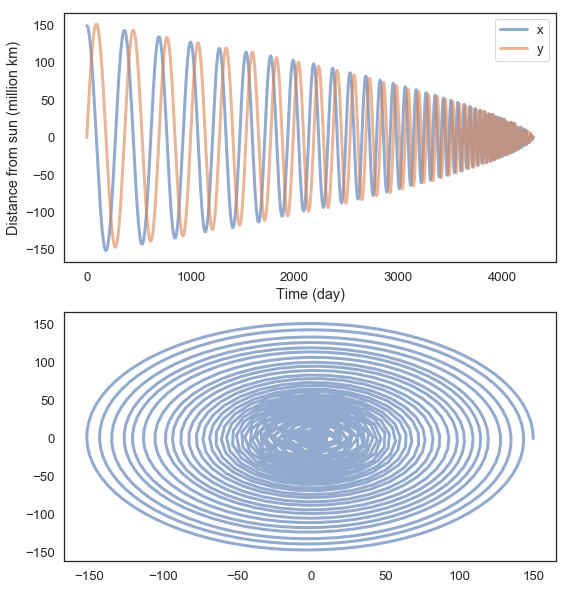

In [68]:
def plot_position(results):
    subplot(2,1,1)
    plot(results.x, label='x')
    plot(results.y, label = 'y')
    decorate(xlabel='Time (day)',
             ylabel='Distance from sun (million km)')
    subplot(2,1,2)
    plot(results.x,results.y, label = 'Position')
    
plot_position(results)

In [79]:
def event_func2(state, t, system):
    """Return the distance between the earth and the sun surfaces
    """
    x,y,vx,vy = state
    position = Vector(x, y) * m
    if(position.y < 1 and vy >0):
        return 0;
    else:
        return 1;

In [85]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[371389617.6088313]]
nfev,4466
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [86]:
results

,x,y,vx,vy
0.000000e+00,1.495979e+11,0.000000e+00,0.000000e+00,30000.000000
4.714045e-08,1.495979e+11,1.414214e-03,-2.796172e-10,30000.000000
5.185450e-07,1.495979e+11,1.555635e-02,-3.075789e-09,30000.000000
5.232590e-06,1.495979e+11,1.569777e-01,-3.103751e-08,30000.000000
5.237304e-05,1.495979e+11,1.571191e+00,-3.106547e-07,30000.000000
5.237776e-04,1.495979e+11,1.571333e+01,-3.106827e-06,30000.000000
5.237823e-03,1.495979e+11,1.571347e+02,-3.106855e-05,30000.000000
5.237827e-02,1.495979e+11,1.571348e+03,-3.106858e-04,30000.000000
5.237828e-01,1.495979e+11,1.571348e+04,-3.106858e-03,30000.000000
5.237828e+00,1.495979e+11,1.571348e+05,-3.106858e-02,30000.000000


In [87]:
t_death = get_last_label(results) * s
print(t_death)
t_death.to(UNITS.day)

371389617.6088313 second


<Quantity(4298.490944546657, 'day')>

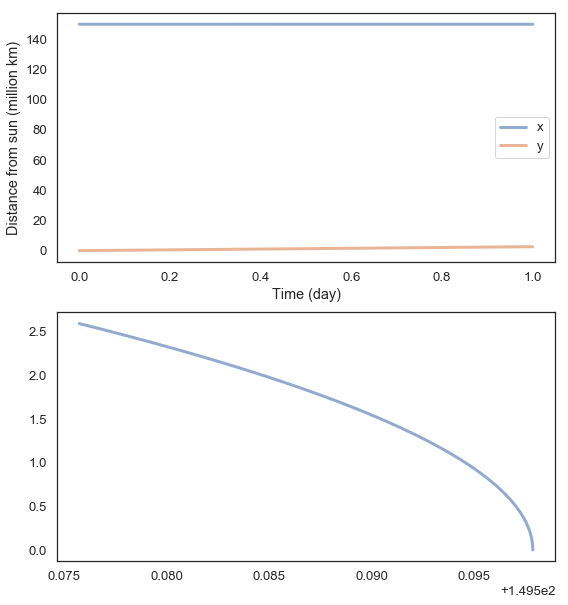

In [88]:
year = 60*60*24
ts = linspace(system.t_0, year, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)
results.index /= 60*60*24

results.x /= 1e9
results.y /= 1e9 #converts to millions of km
plot_position(results)